In [1]:
import sys
sys.path = ["/home/aunai/PHARE/pyphare"] + sys.path

In [2]:
from pyphare.pharesee.run import Run
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d as gf
from numpy import polyfit
from scipy.signal import find_peaks
%matplotlib widget

# Weak perturbations

In [3]:
root_path = "/DATA/fluidecinetique/weak_perturbations"

In [4]:
def get_velocities(r,times, sigma=6):
    for it,t in enumerate(times):
        Vi = r.GetVi(t, merged=True)
        Vix = Vi["Vx"][0]
        xV = Vi["Vx"][1][0]
        if sigma >0:
            v = gf(Vix(xV),sigma)
        else:
            v = Vix(xV)
        if it==0 :
            vt = np.zeros((len(v),len(times)))
        vt[:,it] = v
    return xV, vt

def get_densities(r,times, sigma=6):
    for it,t in enumerate(times):
        N = r.GetNi(t, merged=True)
        Ni = N["rho"][0]
        x = N["rho"][1][0]
        if sigma >0:
            n = gf(Ni(x),sigma)
        else:
            n = Ni(x)
        if it==0 :
            nt = np.zeros((len(n),len(times)))
        nt[:,it] = n
    return x, nt


def get_electric(r,times, sigma=6):
    for it,t in enumerate(times):
        E = r.GetE(t, merged=True)
        Ex = E["Ex"][0]
        x = E["Ex"][1][0]
        if sigma >0:
            e = gf(Ex(x),sigma)
        else:
            e = Ex(x)
        if it==0 :
            et = np.zeros((len(e),len(times)))
        et[:,it] = e
    return x, et


def get_peaks(x,Vs):
    nt = Vs.shape[1]
    positions  = np.zeros((nt,2))
    amplitudes = np.zeros((nt,2))
    for it in range(nt):
        ps = find_peaks(Vs[:,it], height=0.010)
        if (len(ps[0])==1):
            positions[it,0] = x[ps[0]]
            positions[it,1] = x[ps[0]]
            amplitudes[it,0]  = Vs[ps[0][0], it]
            amplitudes[it,1]  = Vs[ps[0][0],it]
        else:
            positions[it,0]  = x[ps[0][0]]
            positions[it,1]  = x[ps[0][1]]
            amplitudes[it,0]  = Vs[ps[0][0], it]
            amplitudes[it,1]  = Vs[ps[0][1],it]
    return positions, amplitudes


def profiles(times, x, Vs, positions, temperature):
    fig, ax = plt.subplots()
    for it,t in enumerate(times):
        ax.plot(x, Vs[:,it], label=r"t={:6.4f}".format(t))
        ax.set_ylim((-0.03, 0.1))
        ax.axhline(0, ls='--', color='k')
        for p in positions[it,:]:
            ax.axvline(p, color="gray", ls="-.")
    ax.set_title("T = {:6.4f}".format(temperature))
    ax.legend()
    
    
def propagation(times, positions, temperature):
    fig,ax = plt.subplots()
    ax.plot(times,positions[:,0], marker="o", color="r", ls="None")
    vl,originl = polyfit(times, positions[:,0], 1)
    ax.plot(times, times*vl+originl, color="r")

    ax.plot(times,positions[:,1], marker="o", color="b", ls="None")
    vr,originr = polyfit(times, positions[:,1], 1)
    ax.plot(times, times*vr+originr, color="b")
    ax.set_title("T = {:6.4f}, Vl = {:6.4f}, Vr = {:6.4f}".format(temperature, vl, vr))
    
    
def damping(times, amplitudes, **kw):
    fig,ax = plt.subplots()
    ax.plot(times,amplitudes[:,0], marker="o", color="r", ls="None")
    ax.plot(times,amplitudes[:,1], marker="o", color="b", ls="None")
    ax.set_ylim((0,0.1))

In [5]:
paths = {0.1:"wp3",
        }

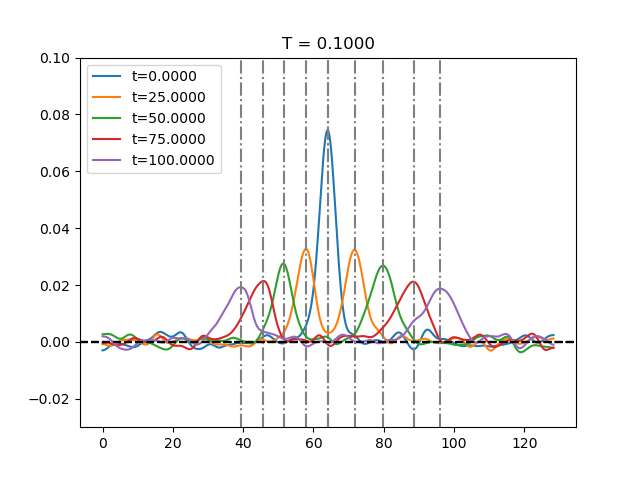

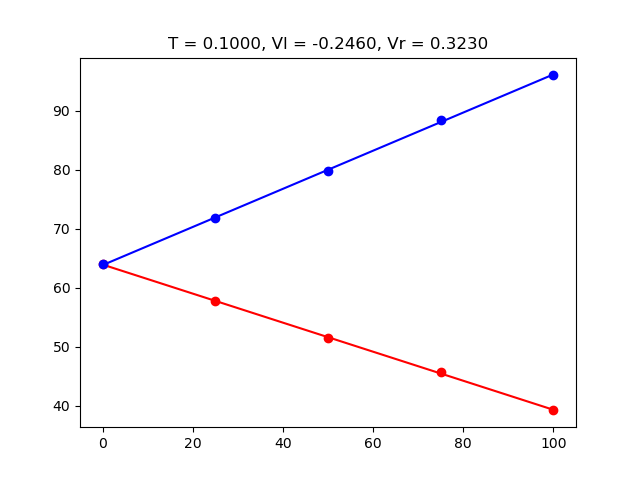

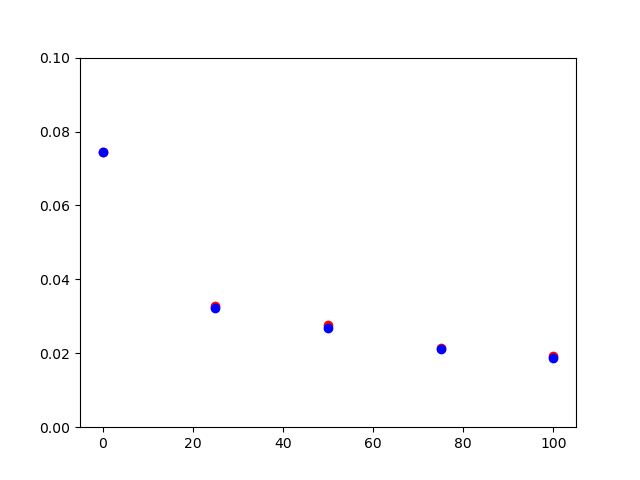

In [6]:
for temperature, path in paths.items():
    r = Run(root_path+"/"+path)
    times   = np.asarray((0,25,50,75,100))
    x, Vs   = get_velocities(r,times, sigma=6)
    positions, amplitudes = get_peaks(x,Vs)
    profiles(times, x, Vs, positions, temperature)
    propagation(times, positions, temperature)
    damping(times, amplitudes)

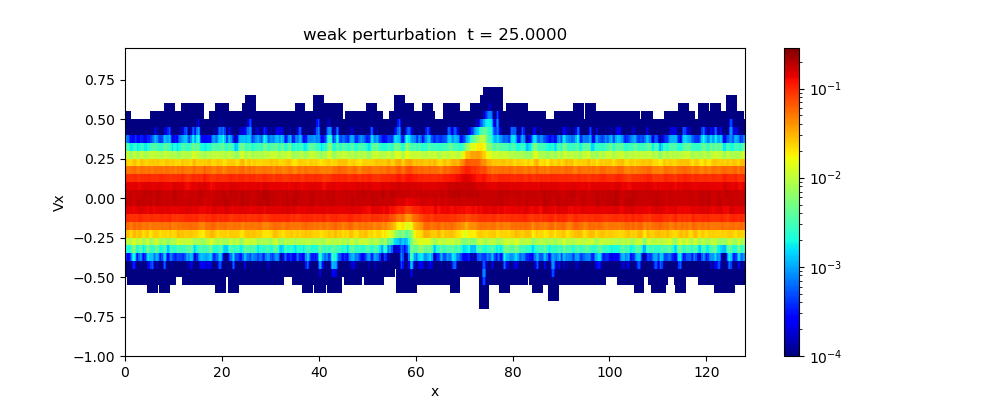

In [11]:
t=25
r = Run(root_path+"/"+"wp3")
ions = r.GetParticles(t, ["protons",])
fig, ax1 = plt.subplots(figsize=(10,4))
p,f = ions.dist_plot(axis=("x", "Vx"), # default [Vx,Vy]
               ax=ax1,            # default creates the figure
               norm = 0.4,     # max value, min is 0
                finest=True,  # only consider finest particles possible
               gaussian_filter_sigma=1,
               vmin=-1,vmax=1,
               dv=0.05,
               title="weak perturbation  t = {:.4f}".format(t), # figure title
              )